In [1]:
from functools import partial

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import torch.nn.functional as F
from tqdm import tqdm
import random

from sklearn.metrics.pairwise import cosine_distances

from transformers import AutoTokenizer, AutoModel

seed = 7631
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset preparation
Load and clean the datasets

In [2]:
# Load and clean 
meddra_ontology = pd.read_csv('./data/raw/meddra_ontology.csv')
llt_to_pt_mapping = pd.read_csv('./data/raw/llt_to_pt_mapping.csv', index_col=0)

In [3]:
meddra_ontology.rename({'ENG': 'term_PT'}, axis=1, inplace=True)
for column in meddra_ontology:
    meddra_ontology[column] = meddra_ontology[column].str.lower()

In [5]:
meddra_ontology.head()

,term_PT,term_HLT,term_HLGT,term_SOC
0,hyperpyrexia,febrile disorders,body temperature conditions,general disorders and administration site cond...
1,haptoglobin decreased,haem metabolism analyses,"metabolic, nutritional and blood gas investiga...",investigations
2,peritoneal chlamydia infection,chlamydial infections,chlamydial infectious disorders,infections and infestations
3,oculogyric crisis,ocular nerve and muscle disorders,ocular neuromuscular disorders,eye disorders
4,diarrhoea infectious neonatal,abdominal and gastrointestinal infections,infections - pathogen unspecified,infections and infestations


In [6]:
llt_to_pt_mapping.rename({'LLT': 'term_LLT', 'PT': 'term_PT'}, axis=1, inplace=True)

# Clean up meddra data
llt_pt_examples = llt_to_pt_mapping.merge(meddra_ontology, how='inner', left_on='term_PT', right_on='term_PT')
llt_pt_examples.head()

,term_LLT,term_PT,term_HLT,term_HLGT,term_SOC
0,muscle pain,myalgia,muscle pains,muscle disorders,musculoskeletal and connective tissue disorders
1,myalgia of lower extremities,myalgia,muscle pains,muscle disorders,musculoskeletal and connective tissue disorders
2,localised muscle pain,myalgia,muscle pains,muscle disorders,musculoskeletal and connective tissue disorders
3,generalised muscle aches,myalgia,muscle pains,muscle disorders,musculoskeletal and connective tissue disorders
4,muscular pain,myalgia,muscle pains,muscle disorders,musculoskeletal and connective tissue disorders


In [7]:
# Save the processed datasets in the processed folder
#meddra_ontology.to_csv('../data/processed/meddra_ontology.csv', index=False, header=True)
#llt_pt_examples.to_csv('../data/processed/llt_pt_examples.csv', index=False, header=True)

# Exploratory Data Analysis

In [8]:
smm4h20_train = pd.read_csv('./data/raw/train.csv')
smm4h20_test = pd.read_csv('./data/raw/test.csv')

cadec_train = pd.read_csv('./data/raw/train_cadec.csv')
cadec_test = pd.read_csv('./data/raw/test_cadec.csv')

col_names = {
    'ae': 'ade', 
    'term': 'term_PT', 
    'term_llt_or_pt': 'LLT_or_PT'
}
smm4h20_train.rename(col_names, axis=1, inplace=True)
smm4h20_test.rename(col_names, axis=1, inplace=True)
cadec_train.rename(col_names, axis=1, inplace=True)
cadec_test.rename(col_names, axis=1, inplace=True)

In [9]:
print(len(smm4h20_train))
print(len(smm4h20_test))
print(len(cadec_train))
print(len(cadec_test))

1154
288
4745
1121


In [10]:
# Setting up the datasets
ade_pt_examples_smm4h20 = pd.concat([smm4h20_train, smm4h20_test])
ade_pt_examples_cadec = pd.concat([cadec_train, cadec_test])
ade_pt_examples = pd.concat([
    ade_pt_examples_smm4h20, 
    ade_pt_examples_cadec
], axis=0).reset_index(drop=True)

In [11]:
ade_pt_examples

,samp_id,text,ade,term_code,term_PT,LLT_or_PT
0,349202688950542336,@theeastmovie thank you so much for getting th...,crippled,10049278,gait inability,unable to walk
1,344764641404145664,vyvanse at 7pm probably wasn't a great idea.. ...,can't sleeeep,10041001,insomnia,sleep loss
2,347986748795650048,08.55 day 21 rivaroxaban diary strange muscle ...,fluid retention,10016807,fluid retention,fluid retention
3,347986748795650048,08.55 day 21 rivaroxaban diary strange muscle ...,muscle spasms,10028333,muscle spasms,muscle spasm
4,347986748795650048,08.55 day 21 rivaroxaban diary strange muscle ...,mobile,10021417,immobile,immobile
...,...,...,...,...,...,...
7303,LIPITOR.990,"short term memory affected, loss of concentrat...",hightened anxiety levels,10002855,anxiety,anxiety
7304,LIPITOR.990,"short term memory affected, loss of concentrat...",generaly feeling unwell like walking in a daze...,10016766,flatulence,flatulence
7305,LIPITOR.990,"short term memory affected, loss of concentrat...",weakness in leg muscles,10047868,muscular weakness,weakness of limbs
7306,LIPITOR.990,"short term memory affected, loss of concentrat...",short term memory affected,10068446,memory impairment,short-term memory impairment


## Classes in datasets and in ontology

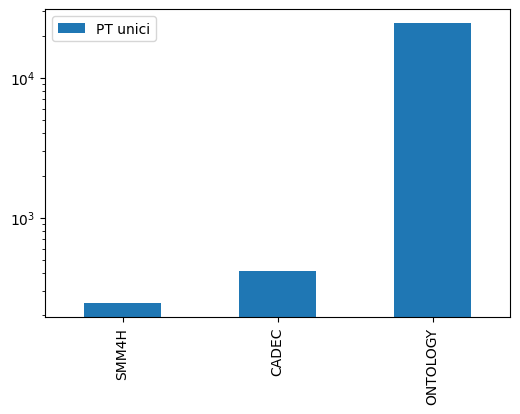

In [52]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

smm4h20_classes = smm4h20_train.copy()
smm4h20_classes['dataset'] = 'SMM4H'
cadec_classes = cadec_train.copy()
cadec_classes['dataset'] = 'CADEC'
meddra_classes = meddra_ontology[['term_PT']].copy()
meddra_classes['dataset'] = 'ONTOLOGY'

df = pd.DataFrame({
    'dataset': ['SMM4H', 'CADEC', 'ONTOLOGY'],
    'PT unici': [
        len(smm4h20_classes.drop_duplicates(['term_PT'])),
        len(cadec_classes.drop_duplicates(['term_PT'])),
        len(meddra_classes.drop_duplicates(['term_PT']))
    ],
}, index=['SMM4H', 'CADEC', 'ONTOLOGY'])

figure = df.plot.bar(logy=True, ax=ax)
fig.savefig('./images/classes_number_comparison.pdf', format='pdf', dpi=fig.dpi, bbox_inches='tight')

## Length of sentences in the dataset

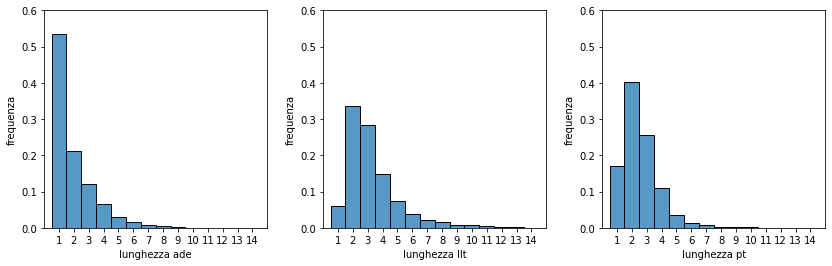

In [40]:
fig = plt.figure(figsize=(14, 4))
ax = plt.GridSpec(1, 3, figure=fig)
ax.update(wspace=0.25, hspace=0.25)

ade_len_ax = plt.subplot(ax[0, 0])
llt_len_ax = plt.subplot(ax[0, 1])
meddra_len_ax = plt.subplot(ax[0, 2])

sns.histplot(ade_pt_examples_smm4h20.loc[:, 'ade'].str.split().str.len(),
             stat='proportion', bins=1,
             ax=ade_len_ax, discrete=True)
sns.histplot(llt_pt_examples.loc[:, 'term_LLT'].str.split().str.len(),
             stat='proportion', bins=1,
             ax=llt_len_ax, discrete=True)
sns.histplot(llt_pt_examples.loc[:, 'term_PT'].str.split().str.len(),
             stat='proportion', bins=1,
             ax=meddra_len_ax, discrete=True)

ade_len_ax.set_xlabel("lunghezza ade")
llt_len_ax.set_xlabel("lunghezza llt")
meddra_len_ax.set_xlabel("lunghezza pt")

ade_len_ax.set_ylabel("frequenza")
llt_len_ax.set_ylabel("frequenza")
meddra_len_ax.set_ylabel("frequenza")

x_lim = 15
y_lim = 0.6
ade_len_ax.set_xticks(range(1, x_lim))
ade_len_ax.set_xlim(0, x_lim)
ade_len_ax.set_ylim(0, y_lim)

llt_len_ax.set_xticks(range(1, x_lim))
llt_len_ax.set_xlim(0, x_lim)
llt_len_ax.set_ylim(0, y_lim)

meddra_len_ax.set_xticks(range(1, x_lim))
meddra_len_ax.set_xlim(0, x_lim)
meddra_len_ax.set_ylim(0, y_lim)

fig.savefig('./images/text_ade_pt_length_smm4h20.pdf', format='pdf', dpi=fig.dpi, bbox_inches='tight')
fig.show()

FileNotFoundError: [Errno 2] No such file or directory: './images/text_ade_pt_length_cadec.pdf'

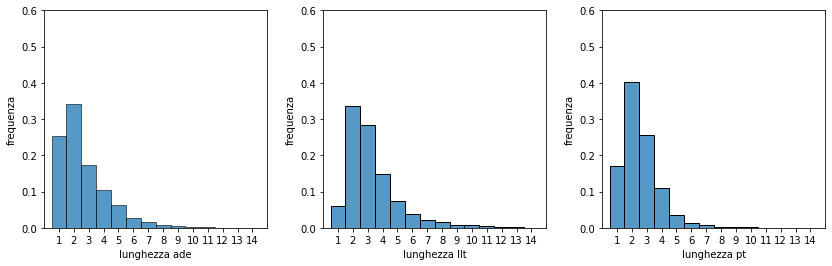

In [28]:
fig = plt.figure(figsize=(14, 4))
ax = plt.GridSpec(1, 3, figure=fig)
ax.update(wspace=0.25, hspace=0.25)

ade_len_ax = plt.subplot(ax[0, 0])
llt_len_ax = plt.subplot(ax[0, 1])
meddra_len_ax = plt.subplot(ax[0, 2])

sns.histplot(ade_meddra_examples_cadec.loc[:, 'ade'].str.split().str.len(),
             stat='proportion', bins=1,
             ax=ade_len_ax, discrete=True)
sns.histplot(llt_pt_examples.loc[:, 'term_LLT'].str.split().str.len(),
             stat='proportion', bins=1,
             ax=llt_len_ax, discrete=True)
sns.histplot(llt_pt_examples.loc[:, 'term_PT'].str.split().str.len(),
             stat='proportion', bins=1,
             ax=meddra_len_ax, discrete=True)

ade_len_ax.set_xlabel("lunghezza ade")
llt_len_ax.set_xlabel("lunghezza llt")
meddra_len_ax.set_xlabel("lunghezza pt")

ade_len_ax.set_ylabel("frequenza")
llt_len_ax.set_ylabel("frequenza")
meddra_len_ax.set_ylabel("frequenza")

x_lim = 15
y_lim = 0.6
ade_len_ax.set_xticks(range(1, x_lim))
ade_len_ax.set_xlim(0, x_lim)
ade_len_ax.set_ylim(0, y_lim)

llt_len_ax.set_xticks(range(1, x_lim))
llt_len_ax.set_xlim(0, x_lim)
llt_len_ax.set_ylim(0, y_lim)

meddra_len_ax.set_xticks(range(1, x_lim))
meddra_len_ax.set_xlim(0, x_lim)
meddra_len_ax.set_ylim(0, y_lim)

fig.savefig('./images/text_ade_pt_length_cadec.pdf', format='pdf', dpi=fig.dpi, bbox_inches='tight')
fig.show()

In [41]:
print(ade_pt_examples['ade'].str.split().str.len().quantile(0.95))
print(llt_pt_examples['term_PT'].str.split().str.len().quantile(0.95))
print(llt_pt_examples['term_LLT'].str.split().str.len().quantile(0.95))

6.0
5.0
7.0


## Most common words in sentences

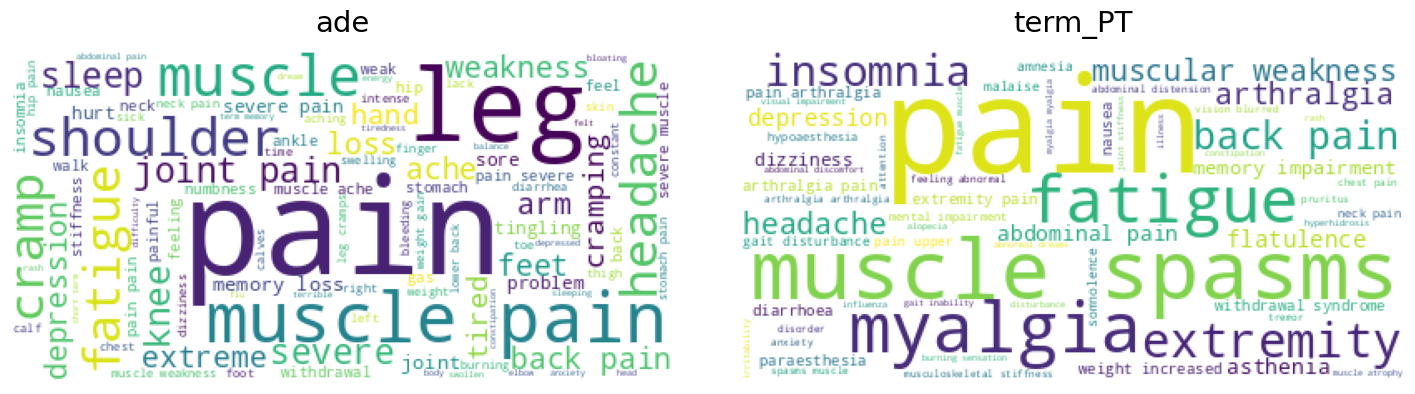

In [54]:
words_in_ade = ade_pt_examples['ade'].str.lower().str.split().sum()
words_in_meddra = ade_pt_examples['term_PT'].str.lower().str.split().sum()

words_in_ade = [ word.strip(" ' .,") for word in words_in_ade]
words_in_meddra = [ word.strip(" ' .,")for word in words_in_meddra]

stopwords = set(STOPWORDS)
cloud_gen = WordCloud(background_color='white', max_words = 100, max_font_size = 80)

fig = plt.figure(figsize=(18, 8))
ax = plt.GridSpec(1, 2, figure=fig)
ax.update(wspace=0.10, hspace=0.10)

plt.subplot(ax[0, 0]).imshow(cloud_gen.generate(' '.join(words_in_ade)))
plt.subplot(ax[0, 1]).imshow(cloud_gen.generate(' '.join(words_in_meddra)))

plt.subplot(ax[0, 0]).set_title("ADE", fontsize=21, pad=15)
plt.subplot(ax[0, 1]).set_title("PT", fontsize=21, pad=15)

plt.subplot(ax[0, 0]).axis("off")
plt.subplot(ax[0, 1]).axis("off")

fig.savefig('./images/ade_pt_word_clouds.pdf', format='pdf', dpi=fig.dpi, bbox_inches='tight')
fig.show()

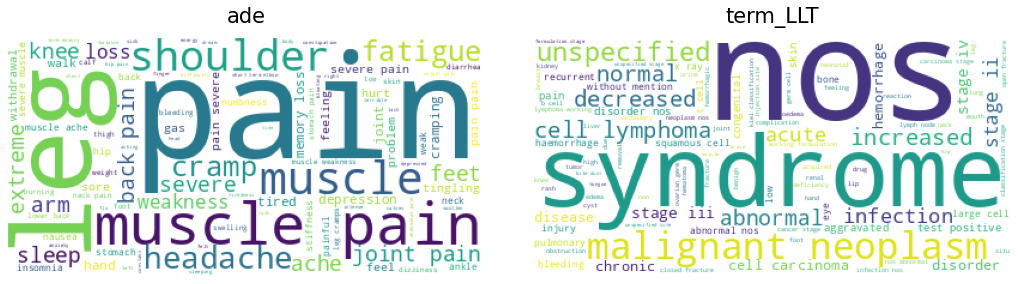

In [44]:
words_in_ade = ade_pt_examples['ade'].str.lower().str.split().sum()
words_in_llt = llt_pt_examples['term_LLT'].str.lower().str.split().sum()

words_in_ade = [ word.strip(" ' .,") for word in words_in_ade]
words_in_llt = [ word.strip(" ' .,")for word in words_in_llt]

stopwords = set(STOPWORDS)
cloud_gen = WordCloud(background_color='white', max_words = 100, max_font_size = 120)

fig = plt.figure(figsize=(18, 8))
ax = plt.GridSpec(1, 2, figure=fig)
ax.update(wspace=0.10, hspace=0.10)

#plt.subplot(ax[0, 0]).imshow(cloud_gen.generate(' '.join(words_in_texts)))
plt.subplot(ax[0, 0]).imshow(cloud_gen.generate(' '.join(words_in_ade)))
plt.subplot(ax[0, 1]).imshow(cloud_gen.generate(' '.join(words_in_llt)))

plt.subplot(ax[0, 0]).set_title("ade", fontsize=21, pad=15)
plt.subplot(ax[0, 1]).set_title("term_LLT", fontsize=21, pad=15)

plt.subplot(ax[0, 0]).axis("off")
plt.subplot(ax[0, 1]).axis("off")

#fig.savefig('./images/ade_llt_word_clouds.pdf', format='pdf', dpi=fig.dpi, bbox_inches='tight')
fig.show()
# NOS, not otherwise specified, indica una diagnosi di un disordine ma non 
# è stata possibile una diagnosi più specifica

In [45]:
llt_pt_examples[llt_pt_examples['term_LLT'].str.contains('nos')]

,term_LLT,term_PT,term_HLT,term_HLGT,term_SOC
70,tricuspid valve disease nos,tricuspid valve disease,tricuspid valvular disorders,cardiac valve disorders,cardiac disorders
115,adenocarcinoma of the cardia stage iv nos,adenocarcinoma gastric,gastric neoplasms malignant,gastrointestinal neoplasms malignant and unspe...,"neoplasms benign, malignant and unspecified (i..."
126,adenocarcinoma gastric stage iv nos,adenocarcinoma gastric,gastric neoplasms malignant,gastrointestinal neoplasms malignant and unspe...,"neoplasms benign, malignant and unspecified (i..."
129,skin vasculitis nos,cutaneous vasculitis,skin vasculitides,skin vascular abnormalities,skin and subcutaneous tissue disorders
130,deficiency anaemia nos,deficiency anaemia,anaemia deficiencies,anaemias nonhaemolytic and marrow depression,blood and lymphatic system disorders
...,...,...,...,...,...
48684,scan nos bone abnormal,bone scan abnormal,musculoskeletal and soft tissue imaging proced...,musculoskeletal and soft tissue investigations...,investigations
48686,renal pelvis cancer nos,malignant neoplasm of renal pelvis,renal pelvis and ureter neoplasms malignant,renal and urinary tract neoplasms malignant an...,"neoplasms benign, malignant and unspecified (i..."
48698,coagulation factor ix level abnormal nos,coagulation factor ix level abnormal,coagulation and bleeding analyses,haematology investigations (incl blood groups),investigations
48701,hepatic cyst nos,hepatic cyst,hepatic and hepatobiliary disorders nec,hepatic and hepatobiliary disorders,hepatobiliary disorders


## Number of term for each level of ontology

In [66]:
meddra_ontology.sort_values('term_SOC')

,term_LLT,term_PT,term_HLT,term_HLGT,term_SOC
42191,lipomelanotic reticulosis,dermatopathic lymphadenopathy,lymphatic system disorders nec,"spleen, lymphatic and reticuloendothelial syst...",blood and lymphatic system disorders
47247,purpura simplex,purpura non-thrombocytopenic,purpuras (excl thrombocytopenic),coagulopathies and bleeding diatheses (excl th...,blood and lymphatic system disorders
41189,acquired coagulation factor deficiency,coagulation factor deficiency,coagulation factor deficiencies,coagulopathies and bleeding diatheses (excl th...,blood and lymphatic system disorders
9806,blood dyscrasia,blood disorder,haematological disorders,haematological disorders nec,blood and lymphatic system disorders
9805,dyscrasia blood (nos),blood disorder,haematological disorders,haematological disorders nec,blood and lymphatic system disorders
...,...,...,...,...,...
18106,venous peripheral insufficiency,peripheral venous disease,non-site specific necrosis and vascular insuff...,"arteriosclerosis, stenosis, vascular insuffici...",vascular disorders
46544,phlebothrombosis,venous thrombosis,non-site specific embolism and thrombosis,embolism and thrombosis,vascular disorders
46543,venous thrombosis nos,venous thrombosis,non-site specific embolism and thrombosis,embolism and thrombosis,vascular disorders
18107,venous reflux,peripheral venous disease,non-site specific necrosis and vascular insuff...,"arteriosclerosis, stenosis, vascular insuffici...",vascular disorders


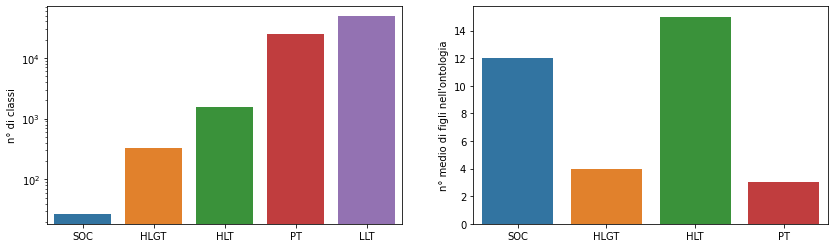

In [46]:
fig = plt.figure(figsize=(14, 4))
ax = plt.GridSpec(1, 2, figure=fig)
#ax.update(wspace=0.25, hspace=0.25)

classes_ax = plt.subplot(ax[0, 0])
mean_n_of_children_ax = plt.subplot(ax[0, 1])

n_of_classes_for_level = pd.DataFrame({
    'SOC': len(meddra_ontology['term_SOC'].unique()), 
    'HLGT': len(meddra_ontology['term_HLGT'].unique()), 
    'HLT': len(meddra_ontology['term_HLT'].unique()),
    'PT': len(meddra_ontology['term_PT'].unique()),
    'LLT': len(llt_pt_examples['term_LLT'].unique())
}, index=[0])

subterms_for_level = pd.DataFrame({ 
    'SOC': int(meddra_ontology.drop_duplicates(['term_HLGT']).groupby('term_SOC').count().mean()['term_HLGT']), 
    'HLGT': int(meddra_ontology.drop_duplicates(['term_HLT']).groupby('term_HLGT').count().mean()['term_HLT']),
    'HLT': int(meddra_ontology.drop_duplicates(['term_PT']).groupby('term_HLT').count().mean()['term_PT']),
    'PT': int(llt_pt_examples.drop_duplicates(['term_LLT']).groupby('term_PT').count().mean()['term_LLT'])
}, index=[0])

sns.barplot(data=n_of_classes_for_level, ax=classes_ax)
classes_ax.set_ylabel("n° di classi")
classes_ax.set_yscale('log')
sns.barplot(data=subterms_for_level, ax=mean_n_of_children_ax)
mean_n_of_children_ax.set_ylabel("n° medio di figli nell'ontologia")

fig.savefig('./images/ontology_classes_and_level_distribution.pdf', format='pdf', dpi=fig.dpi, bbox_inches='tight')
fig.show()

## Compute metrics on dataset embeddings

In [67]:
model_name = 'allenai/scibert_scivocab_uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()
model.to(device)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [81]:
ade_pt_examples.drop_duplicates(['ade', 'term_PT'], inplace=True)
ade_pt_examples.head()
ade_with_ontology = ade_pt_examples.merge(meddra_ontology, on='term_PT')
ade_with_ontology

,samp_id,text,ade,term_code,term_PT,LLT_or_PT,term_HLT,term_HLGT,term_SOC
0,349202688950542336,@theeastmovie thank you so much for getting th...,crippled,10049278,gait inability,unable to walk,gait disturbances,general system disorders nec,general disorders and administration site cond...
1,343238435450015744,"so unfair, i never get the good side effects o...",cant really walk,10049278,gait inability,unable to walk,gait disturbances,general system disorders nec,general disorders and administration site cond...
2,333278830980648960,@integratemd i sure wish my doctor had told me...,disable,10049278,gait inability,unable to walk,gait disturbances,general system disorders nec,general disorders and administration site cond...
3,346070352121712640,@indiescent @serarrist when i weaned myself of...,couldn?t walk,10049278,gait inability,unable to walk,gait disturbances,general system disorders nec,general disorders and administration site cond...
4,LIPITOR.273,extreme muscle and joint pain; extreme fatigue...,inability to walk,10049278,gait inability,unable to walk,gait disturbances,general system disorders nec,general disorders and administration site cond...
...,...,...,...,...,...,...,...,...,...
4076,LIPITOR.834,"i had an extreme reaction - tunnel vision, ver...",complete weakness in the right side of my body,10019467,hemiparesis,hemiparesis (right),paralysis and paresis (excl cranial nerve),movement disorders (incl parkinsonism),nervous system disorders
4077,LIPITOR.623,"skipping heart beats, fast and slow heartbeat,...",fast and slow heartbeat,10006093,bradycardia,bradycardia,rate and rhythm disorders nec,cardiac arrhythmias,cardiac disorders
4078,LIPITOR.623,"skipping heart beats, fast and slow heartbeat,...",skipping heart beats,10013646,extrasystoles,dropped beats,rate and rhythm disorders nec,cardiac arrhythmias,cardiac disorders
4079,ARTHROTEC.133,"stomach queasy, but very mild, and goes away. ...",menopausal,10027296,menopause,menopausal,age related issues,age related factors,social circumstances


In [70]:
batch_size = 256
def encode_samples(model, samples):
    with torch.no_grad():
        sample_encodings = torch.zeros((len(samples), model.config.hidden_size), device=device)
        for idx in tqdm(range(0, len(samples), batch_size), total=len(samples) // batch_size):
            batch_start = idx
            batch_end = min(len(samples), batch_start+batch_size)
            model_inputs = tokenizer(samples[batch_start:batch_end], truncation=True, padding='max_length', max_length=32, return_tensors='pt').to(device)
            model_output = model(**model_inputs, output_hidden_states=True)
            model_prediction = model_output.pooler_output
            sample_encodings[batch_start:batch_end] = model_prediction
    return sample_encodings

In [88]:
ade_embeddings = encode_samples(model, ade_with_ontology['ade'].tolist())

ade_distances = dict()
for term in ['term_PT', 'term_HLT', 'term_HLGT', 'term_SOC']:
    term_embeddings = encode_samples(model, ade_with_ontology[term].tolist())
    avg_similarity = F.cosine_similarity(ade_embeddings, term_embeddings).mean()
    
    ade_distances[term] = avg_similarity.item()
    
print(ade_distances)

16it [00:01, 10.98it/s]                                                    
16it [00:01, 10.50it/s]                                                    
16it [00:01, 10.99it/s]                                                    
16it [00:01, 11.01it/s]                                                    
16it [00:01, 11.01it/s]                                                    


{'term_PT': 0.8305976390838623, 'term_HLT': 0.7934150695800781, 'term_HLGT': 0.7679360508918762, 'term_SOC': 0.7818458676338196}


In [89]:
llt_pt_examples.drop_duplicates(['term_LLT', 'term_PT'], inplace=True)
llt_pt_examples_sample = llt_pt_examples.sample(frac=1)

llt_embeddings = encode_samples(model, llt_pt_examples['term_LLT'].tolist())

llt_distances = dict()
for term in ['term_PT', 'term_HLT', 'term_HLGT', 'term_SOC']:
    term_embeddings = encode_samples(model, llt_pt_examples[term].tolist())
    avg_similarity = F.cosine_similarity(llt_embeddings, term_embeddings).mean()
    
    llt_distances[term] = avg_similarity.item()
    
print(llt_distances)

191it [00:18, 10.47it/s]                                                   
191it [00:18, 10.45it/s]                                                   
191it [00:18, 10.43it/s]                                                   
191it [00:18, 10.41it/s]                                                   
191it [00:18, 10.42it/s]                                                   

{'term_PT': 0.8850570917129517, 'term_HLT': 0.8055439591407776, 'term_HLGT': 0.790382444858551, 'term_SOC': 0.7858040928840637}
